# Visión por Computadora
### Integrantes
* Sergio Orellana 221122
* Rodrigo Mansilla 22611
* Ricardo Chuy 221007

## Task 3: Detección de Rasgaduras en Tela Denim


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Funciones Auxiliares

In [124]:
def fft2(img):
    f = np.fft.fft2(img.astype(np.float32))
    return np.fft.fftshift(f)

def ifft2(fshift):
    img_back = np.fft.ifft2(np.fft.ifftshift(fshift))
    return np.real(img_back)

def gaussian_lowpass(shape, sigma):
    rows, cols = shape
    crow, ccol = rows//2, cols//2
    y = np.arange(rows) - crow
    x = np.arange(cols) - ccol
    X, Y = np.meshgrid(x, y)
    D2 = X**2 + Y**2
    return np.exp(-D2/(2*sigma*sigma)).astype(np.float32)

def show3(a, b, c, t1, t2, t3, cm1='gray', cm2='gray', cm3='gray', figsize=(15,5)):
    fig, ax = plt.subplots(1,3, figsize=figsize)
    ax[0].imshow(a, cmap=cm1); ax[0].set_title(t1); ax[0].axis('off')
    ax[1].imshow(b, cmap=cm2); ax[1].set_title(t2); ax[1].axis('off')
    ax[2].imshow(c, cmap=cm3); ax[2].set_title(t3); ax[2].axis('off')
    plt.tight_layout(); plt.show()

### Pipeline Principal

Imagen cargada: (512, 512)


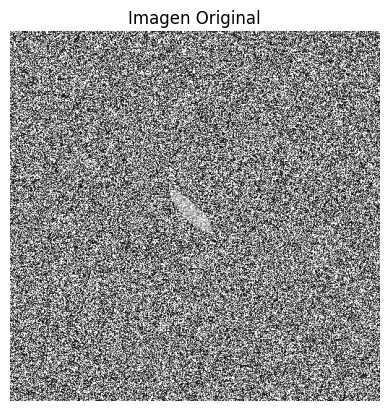

In [77]:
img = cv2.imread('./imgs/textile_defect.jpg', cv2.IMREAD_GRAYSCALE)
print(f"Imagen cargada: {img.shape}")
plt.imshow(img, cmap='gray')
plt.title('Imagen Original')
plt.axis('off')
plt.show()

### Paso 1: FFT y Filtro Híbrido (Low-Pass + Notch)

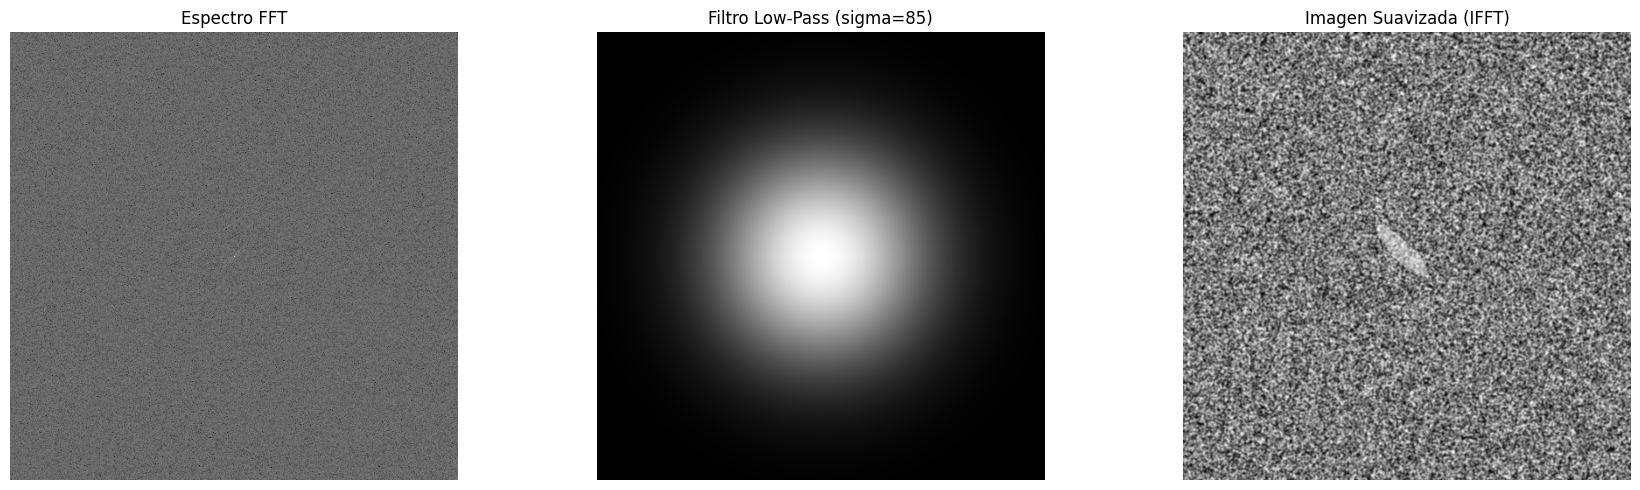

In [150]:
F = fft2(img)
mag = np.abs(F)

sigma = 85
lp = gaussian_lowpass(img.shape, sigma=sigma)

notch = auto_notch_mask(np.abs(F), k=6, r=7, keep_center=30)

H = lp * notch
img_smooth = ifft2(F * H)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(20*np.log(mag+1), cmap='gray')
axes[0].set_title('Espectro FFT')
axes[0].axis('off')

axes[1].imshow(lp, cmap='gray')
axes[1].set_title(f'Filtro Low-Pass (sigma={sigma})')
axes[1].axis('off')

axes[2].imshow(img_smooth_u8, cmap='gray')
axes[2].set_title('Imagen Suavizada (IFFT)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### Paso 2: Residuo y Segmentación (Threshold)

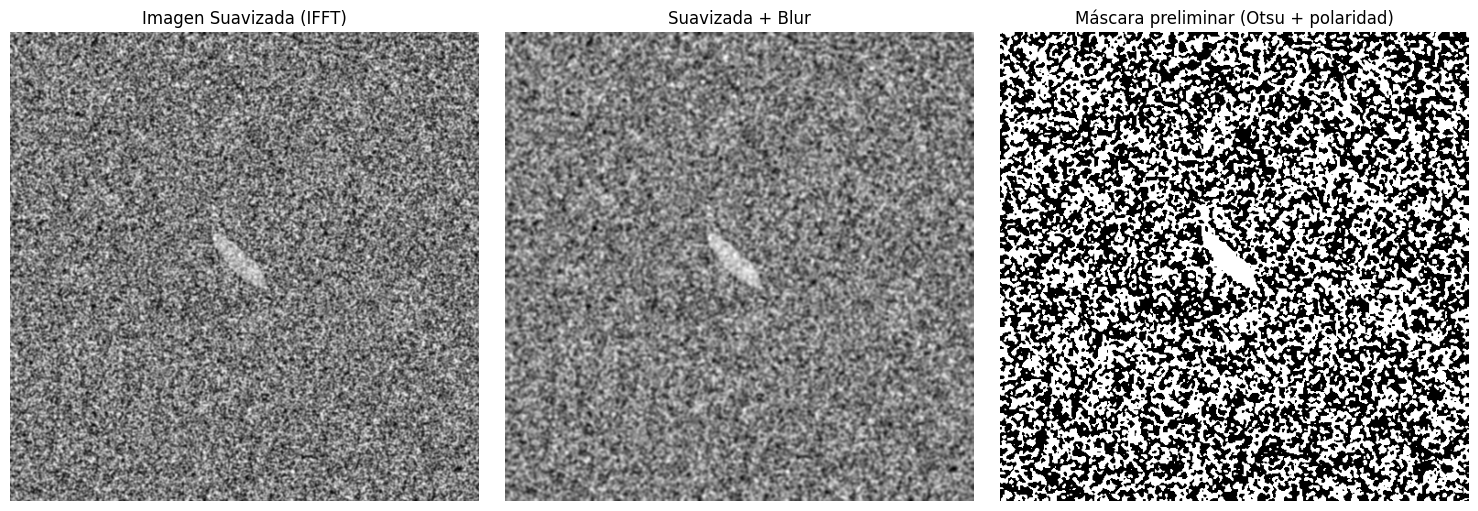

In [182]:

smooth = img_smooth_u8.copy()

smooth_blur = cv2.GaussianBlur(smooth, (5, 5), 0)

_, th     = cv2.threshold(smooth_blur, 0, 255, cv2.THRESH_BINARY     + cv2.THRESH_OTSU)
_, th_inv = cv2.threshold(smooth_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

def white_ratio(mask):
    return np.mean(mask == 255)

def score_ratio(r):
    if 0.01 <= r <= 0.40:
        return 1.0 - abs(r - 0.10)
    return -1.0

mask0 = th if score_ratio(white_ratio(th)) >= score_ratio(white_ratio(th_inv)) else th_inv

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(smooth, cmap='gray');      axes[0].set_title('Imagen Suavizada (IFFT)'); axes[0].axis('off')
axes[1].imshow(smooth_blur, cmap='gray'); axes[1].set_title('Suavizada + Blur');        axes[1].axis('off')
axes[2].imshow(mask0, cmap='gray');       axes[2].set_title('Máscara preliminar (Otsu + polaridad)'); axes[2].axis('off')
plt.tight_layout(); plt.show()



### Paso 3: Refinamiento Morfológico

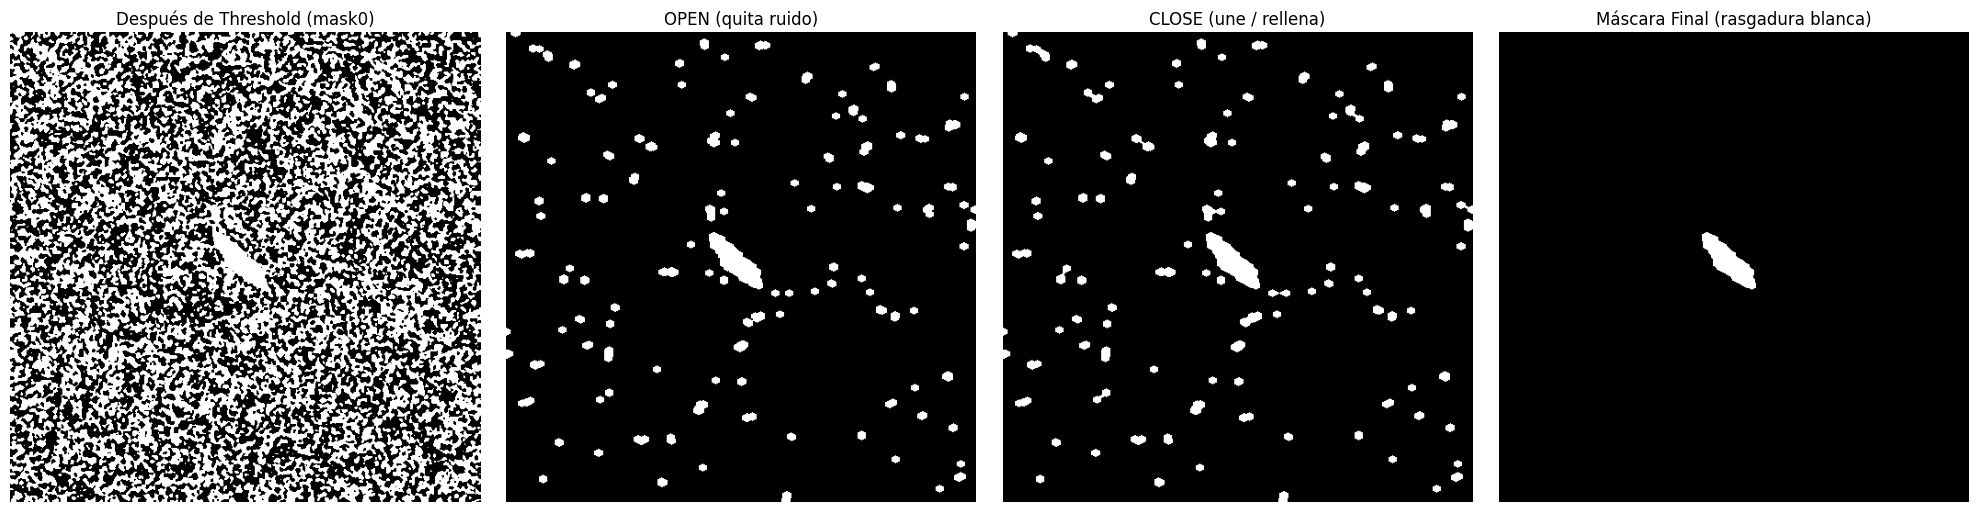

final_mask blancos: 1591


In [183]:

k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_open = cv2.morphologyEx(mask0, cv2.MORPH_OPEN, k_open, iterations=2)


k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
mask_close = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, k_close, iterations=1)

num, labels, stats, _ = cv2.connectedComponentsWithStats(mask_close, connectivity=8)
final_mask = np.zeros_like(mask_close)

h, w = mask_close.shape
best_i = -1
best_score = -1.0

for i in range(1, num):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    ww = stats[i, cv2.CC_STAT_WIDTH]
    hh = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]

    if area < 200:
        continue

    touches_border = (x == 0) or (y == 0) or (x + ww >= w) or (y + hh >= h)
    if touches_border:
        continue

    elong = max(ww, hh) / (min(ww, hh) + 1e-5)

    if elong < 1.6:
        continue

    score = area * elong
    if score > best_score:
        best_score = score
        best_i = i

if best_i == -1 and num > 1:
    areas = stats[1:, cv2.CC_STAT_AREA]
    best_i = 1 + int(np.argmax(areas))

if best_i != -1:
    final_mask[labels == best_i] = 255
else:
    final_mask = mask_close.copy()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(mask0, cmap='gray');       axes[0].set_title('Después de Threshold (mask0)'); axes[0].axis('off')
axes[1].imshow(mask_open, cmap='gray');   axes[1].set_title('OPEN (quita ruido)');          axes[1].axis('off')
axes[2].imshow(mask_close, cmap='gray');  axes[2].set_title('CLOSE (une / rellena)');       axes[2].axis('off')
axes[3].imshow(final_mask, cmap='gray');  axes[3].set_title('Máscara Final (rasgadura blanca)'); axes[3].axis('off')
plt.tight_layout(); plt.show()

print("final_mask blancos:", int((final_mask == 255).sum()))


### Resultado Final

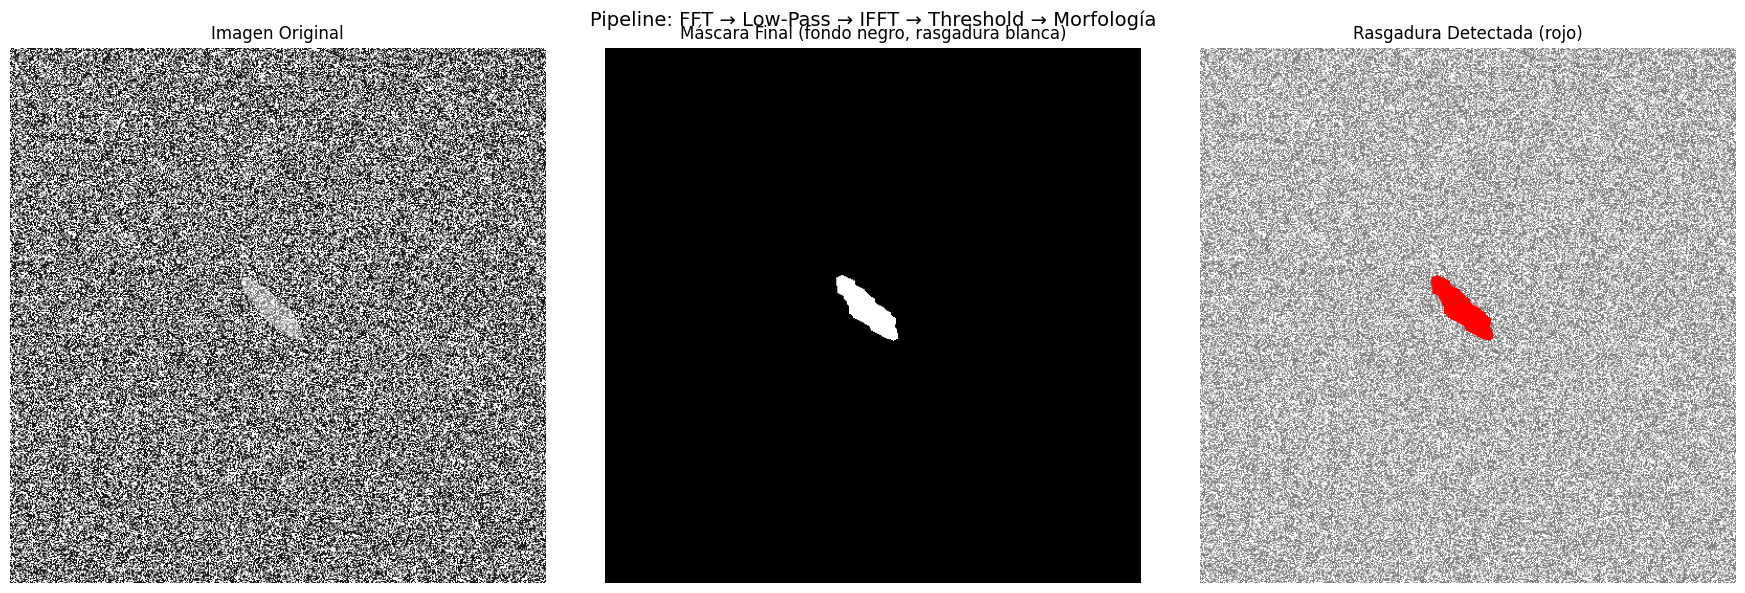

In [179]:
overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
overlay[final_mask == 255] = [0, 0, 255]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img, cmap='gray'); axes[0].set_title('Imagen Original'); axes[0].axis('off')
axes[1].imshow(final_mask, cmap='gray'); axes[1].set_title('Máscara Final (fondo negro, rasgadura blanca)'); axes[1].axis('off')
axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); axes[2].set_title('Rasgadura Detectada (rojo)'); axes[2].axis('off')
plt.suptitle('Pipeline: FFT → Low-Pass → IFFT → Threshold → Morfología', fontsize=14)
plt.tight_layout()
plt.show()


¿Qué pasa si larasgadura es muy pequeña? ¿Qué pasa si cambiamos el tipo de tela? ¿Es su solución robusta o
específica para esta imagen?

Una rasgadura muy pequeña representa una alta frecuencia, o puede representarse como una dado que el filtrado de Fourier, sus umbrales y la morfologìa tienden a suprimir estructruras de pocos pìxeles. Si se cambia el tipo de tela se cambian los picos en frecuencia, al desplazarse oi dejar de aparecer, por lo que el filtro acepte textura y borre parte de la rajadura. La solución se adapta a tejidos con patrones similares y en escala símilar, recalibrando kernels y los parámetros.

### Referencias 
MIT News. (2009). Explained: Fourier transforms. Massachusetts Institute of Technology.
https://news.mit.edu/2009/explained-fourier

Wray Castle. (n.d.). DFT – Discrete Fourier Transform.
https://wraycastle.com/es/blogs/knowledge-base/dft-discrete-fourier-transform

Bryan, P. B. (2018). Understand the convolution theorem. Medium.
https://peterbbryan.medium.com/understand-the-convolution-theorem-ff039caa745e

University of Cambridge, Department of Structural & Molecular Biology. (n.d.). Convolution.
https://www-structmed.cimr.cam.ac.uk/Course/Convolution/convolution.html

Perera, S. (2020). OpenCV morphological dilation and erosion. Medium.
https://medium.com/@sasaniperera/opencv-morphological-dilation-and-erosion-fab65c29efb3

Scaler Topics. (n.d.). Erosion and dilation in image processing.
https://www.scaler.com/topics/erosion-and-dilation-in-image-processing/

GeeksforGeeks. (n.d.). Difference between dilation and erosion.
https://www.geeksforgeeks.org/computer-vision/difference-between-dilation-and-erosion/

Anshul. (2019). Opening morphological operation in image processing. Medium.
https://medium.com/@anshul16/opening-morphological-operation-image-processing-bbdbe210e3bc